In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
# kagglehub.login()
# //read from kaggle.json
from kagglehub.config import set_kaggle_credentials

import json
with open('kaggle.json', 'r') as f:
    kaggle_creds = json.load(f)
    
# kagglehub.login(username=kaggle_creds['username'], key=kaggle_creds['key'])
set_kaggle_credentials(username=kaggle_creds['username'], api_key=kaggle_creds['key'])


Kaggle credentials set.


In [17]:
# Standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series specific
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Utilities
import sys
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (18, 12)


## Timeseries Time!

### Final Processed Dataset (`ts_train`)
✅ Ready for modeling
- Contains only selected features (22 features)
- Properly split for time series (70/15/15)
- Missing values handled (forward fill applied) 
- Pickled and ready to use
- Used throughout the transformer benchmarking code

### Raw Dataset (`train_ts`) 
❌ Not suitable for direct use
- Contains all 896 features
- Not split for time series
- May have missing values
- Too large for efficient modeling

In [1]:
# open pickle file 
import pandas as pd
import matplotlib.pyplot as plt
variables = pd.read_pickle('/home/mahta/Time-Series-Library/crypto/data/preprocessed.pkl')
ts_train = variables['ts_train']
ts_val = variables['ts_val']
ts_test = variables['ts_test']

🔍 CRYPTO DATA ANALYSIS & VISUALIZATION
�� Dataset Shapes:
  ts_train: (368120, 23) (70% of data)
  ts_val:   (78883, 23) (15% of data)
  ts_test:  (78884, 23) (15% of data)
  Total samples: 525,887

🎯 Features (22 total):
  X-features: 17 (engineered)
  Trading features: 5 (raw market data)

✅ Data Quality:
  Missing values in ts_train: 0
  Missing values in ts_val:   0
  Missing values in ts_test:  0

🎯 Target Variable (label) Statistics:
  Mean: 0.0215
  Std:  1.0020
  Min:  -24.4166
  Max:  20.7403


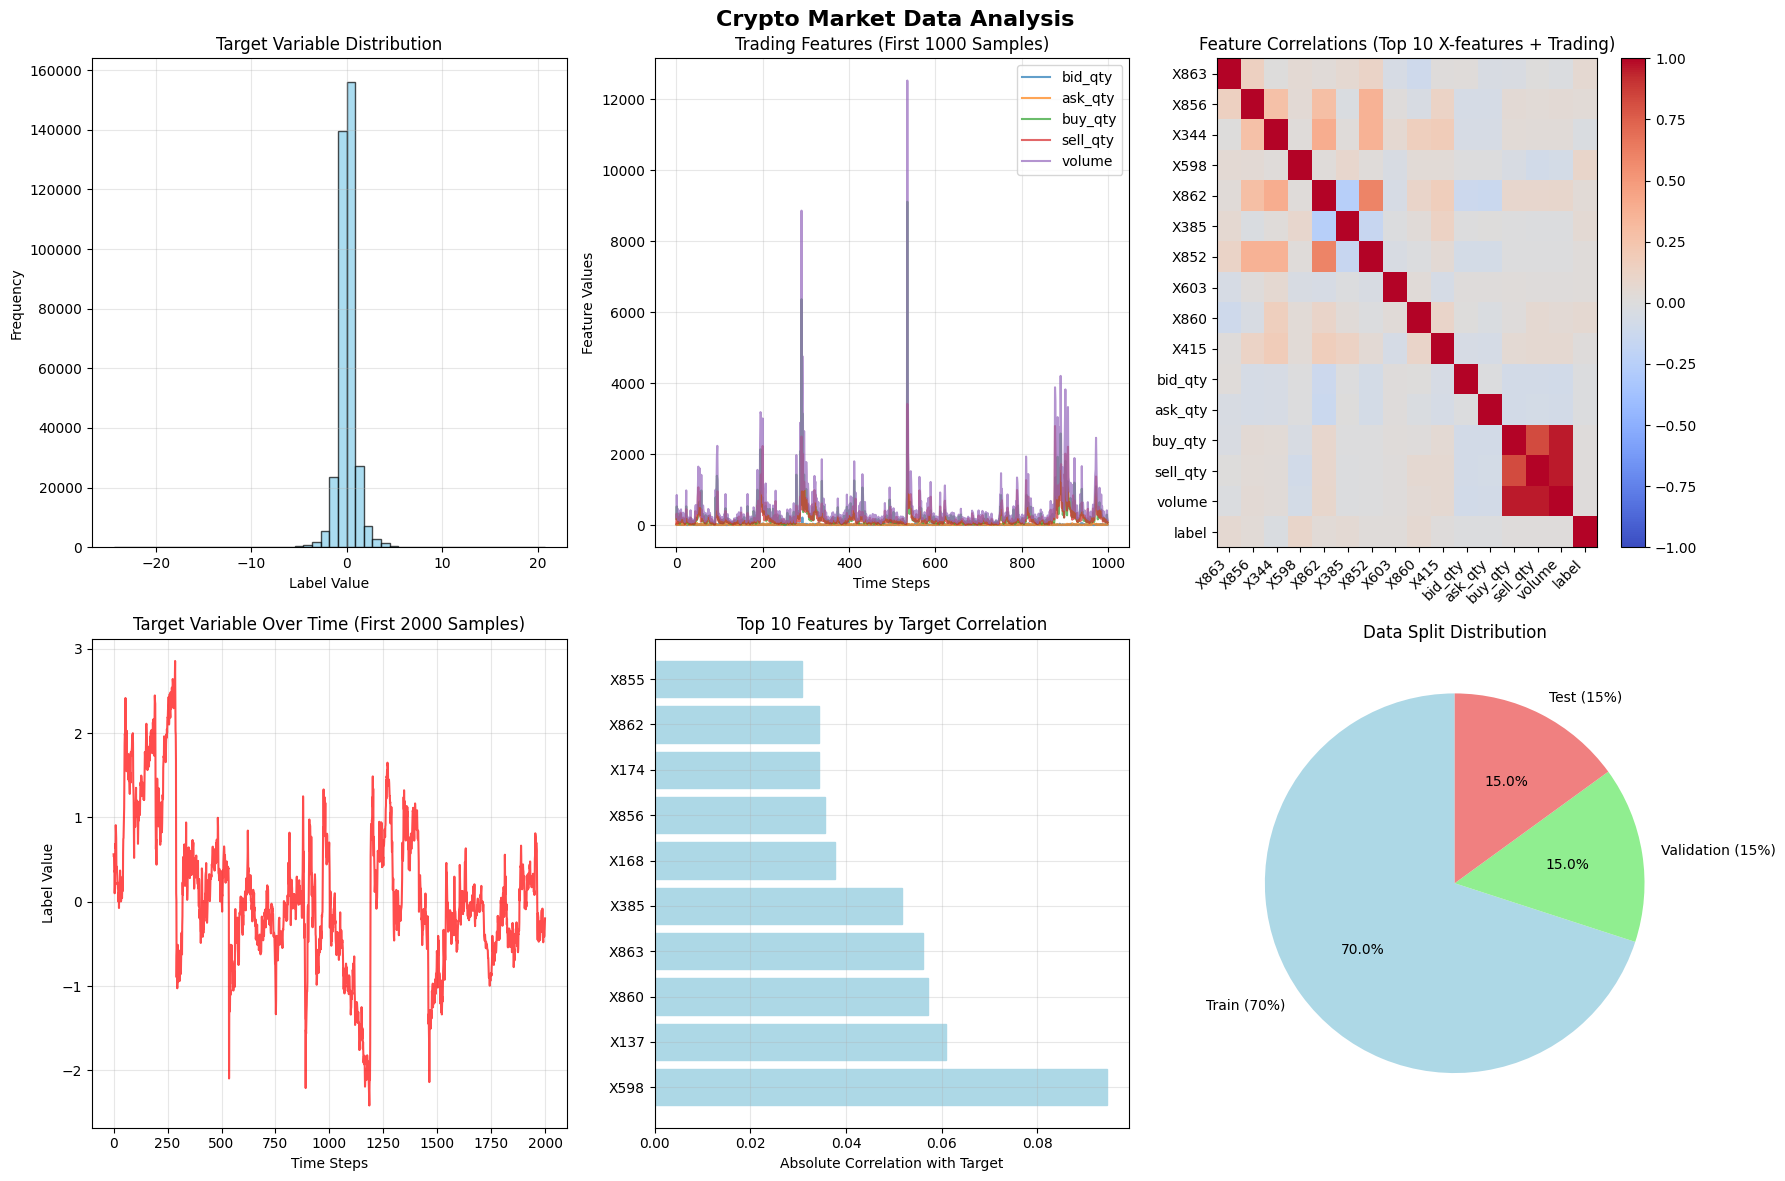


💡 KEY INSIGHTS:
  1. Data spans 525,887 time steps
  2. Each time step represents 1 minute of crypto market data
  3. Target variable shows 1.0020 volatility
  4. 17 engineered features + 5 raw features
  5. Data is clean (no missing values) and ready for time series modeling

🏆 TOP 5 FEATURES BY TARGET CORRELATION:
  1. X598: 0.0945 (X-feature)
  2. X137: 0.0608 (X-feature)
  3. X860: 0.0571 (X-feature)
  4. X863: 0.0561 (X-feature)
  5. X385: 0.0516 (X-feature)

⏰ TIME SERIES CHARACTERISTICS:
  - Sequential data: 368,120 → 78,883 → 78,884
  - No temporal leakage (proper time-aware split)
  - Ready for transformer models with sequence length < 36,812

✅ DATA READY FOR TRANSFORMER BENCHMARKING!


In [9]:
# Data Visualization and Analysis
print("🔍 CRYPTO DATA ANALYSIS & VISUALIZATION")
print("=" * 50)

# Basic dataset info
print(f"�� Dataset Shapes:")
print(f"  ts_train: {ts_train.shape} (70% of data)")
print(f"  ts_val:   {ts_val.shape} (15% of data)")
print(f"  ts_test:  {ts_test.shape} (15% of data)")
print(f"  Total samples: {len(ts_train) + len(ts_val) + len(ts_test):,}")

# Feature analysis
features = [col for col in ts_train.columns if col != 'label']
print(f"\n🎯 Features ({len(features)} total):")
print(f"  X-features: {len([f for f in features if f.startswith('X')])} (engineered)")
print(f"  Trading features: {len([f for f in features if not f.startswith('X')])} (raw market data)")

# Data quality check
print(f"\n✅ Data Quality:")
print(f"  Missing values in ts_train: {ts_train.isnull().sum().sum()}")
print(f"  Missing values in ts_val:   {ts_val.isnull().sum().sum()}")
print(f"  Missing values in ts_test:  {ts_test.isnull().sum().sum()}")

# Target variable analysis
print(f"\n🎯 Target Variable (label) Statistics:")
print(f"  Mean: {ts_train['label'].mean():.4f}")
print(f"  Std:  {ts_train['label'].std():.4f}")
print(f"  Min:  {ts_train['label'].min():.4f}")
print(f"  Max:  {ts_train['label'].max():.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Crypto Market Data Analysis', fontsize=16, fontweight='bold')

# 1. Target variable distribution
axes[0, 0].hist(ts_train['label'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Target Variable Distribution')
axes[0, 0].set_xlabel('Label Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Trading features over time (first 1000 samples for clarity)
sample_size = min(1000, len(ts_train))
trading_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']

for feature in trading_features:
    axes[0, 1].plot(ts_train[feature].iloc[:sample_size], label=feature, alpha=0.7)
axes[0, 1].set_title('Trading Features (First 1000 Samples)')
axes[0, 1].set_xlabel('Time Steps')
axes[0, 1].set_ylabel('Feature Values')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature correlations heatmap (top 10 X-features + trading features)
top_x_features = [f for f in features if f.startswith('X')][:10]
correlation_features = top_x_features + trading_features + ['label']
corr_matrix = ts_train[correlation_features].corr()

im = axes[0, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[0, 2].set_title('Feature Correlations (Top 10 X-features + Trading)')
axes[0, 2].set_xticks(range(len(correlation_features)))
axes[0, 2].set_yticks(range(len(correlation_features)))
axes[0, 2].set_xticklabels(correlation_features, rotation=45, ha='right')
axes[0, 2].set_yticklabels(correlation_features)
plt.colorbar(im, ax=axes[0, 2])

# 4. Target variable over time (first 2000 samples)
axes[1, 0].plot(ts_train['label'].iloc[:2000], color='red', alpha=0.7)
axes[1, 0].set_title('Target Variable Over Time (First 2000 Samples)')
axes[1, 0].set_xlabel('Time Steps')
axes[1, 0].set_ylabel('Label Value')
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature importance (correlation with target)
feature_correlations = []
for feature in features:
    corr = ts_train[feature].corr(ts_train['label'])
    feature_correlations.append((feature, abs(corr)))

feature_correlations.sort(key=lambda x: x[1], reverse=True)
top_features = feature_correlations[:10]

feature_names = [f[0] for f in top_features]
correlations = [f[1] for f in top_features]

bars = axes[1, 1].barh(range(len(feature_names)), correlations, color='lightgreen')
axes[1, 1].set_title('Top 10 Features by Target Correlation')
axes[1, 1].set_xlabel('Absolute Correlation with Target')
axes[1, 1].set_yticks(range(len(feature_names)))
axes[1, 1].set_yticklabels(feature_names)
axes[1, 1].grid(True, alpha=0.3)

# Color bars based on feature type
for i, feature in enumerate(feature_names):
    if feature.startswith('X'):
        bars[i].set_color('lightblue')
    else:
        bars[i].set_color('orange')

# 6. Data splits visualization
split_sizes = [len(ts_train), len(ts_val), len(ts_test)]
split_labels = ['Train (70%)', 'Validation (15%)', 'Test (15%)']
colors = ['lightblue', 'lightgreen', 'lightcoral']

axes[1, 2].pie(split_sizes, labels=split_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Data Split Distribution')

plt.tight_layout()
plt.show()

# Additional insights
print(f"\n💡 KEY INSIGHTS:")
print(f"  1. Data spans {len(ts_train) + len(ts_val) + len(ts_test):,} time steps")
print(f"  2. Each time step represents 1 minute of crypto market data")
print(f"  3. Target variable shows {ts_train['label'].std():.4f} volatility")
print(f"  4. {len([f for f in features if f.startswith('X')])} engineered features + {len([f for f in features if not f.startswith('X')])} raw features")
print(f"  5. Data is clean (no missing values) and ready for time series modeling")

# Show top correlated features
print(f"\n🏆 TOP 5 FEATURES BY TARGET CORRELATION:")
for i, (feature, corr) in enumerate(feature_correlations[:5]):
    feature_type = "X-feature" if feature.startswith('X') else "Trading feature"
    print(f"  {i+1}. {feature}: {corr:.4f} ({feature_type})")

# Time series characteristics
print(f"\n⏰ TIME SERIES CHARACTERISTICS:")
print(f"  - Sequential data: {len(ts_train):,} → {len(ts_val):,} → {len(ts_test):,}")
print(f"  - No temporal leakage (proper time-aware split)")
print(f"  - Ready for transformer models with sequence length < {len(ts_train)//10:,}")

print(f"\n✅ DATA READY FOR TRANSFORMER BENCHMARKING!")

In [9]:
!squeue -u $USER

          JOBID     USER      ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
       46032474    mahta def-gdumas85  crypto_python  PD    8:00:00     1    8 gres:gpu:1     64G  (ReqNodeNotAvail, UnavailableNodes:ng[10101-10104,10201-10204,10301-10304,10401-10404,10501-10504,10601-10610,10701-10712,10801-10808,10901-10906,11001-11006,11101-11106,20101-20104,20201-20204,20301-20303,20403,30601-30605,30701-30712,31001-31006,31101-31104,31201-31205,31301-31305,31401-31402]) 


In [1]:
# Add this cell to your notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
import gc
from typing import Dict, List, Any
import sys
import os
from sklearn.preprocessing import StandardScaler

# Add models to path
sys.path.append(os.path.dirname(os.getcwd()))

# Import all models
from models import (
    Autoformer, Transformer, TimesNet, Nonstationary_Transformer, DLinear, 
    FEDformer, Informer, LightTS, Reformer, ETSformer, Pyraformer, PatchTST, 
    MICN, Crossformer, FiLM, iTransformer, Koopa, TiDE, FreTS, TimeMixer, 
    TSMixer, SegRNN, MambaSimple, TemporalFusionTransformer, SCINet, PAttn, 
    TimeXer, WPMixer, MultiPatchFormer
)

class ReconstructionDataset(Dataset):
    def __init__(self, data, seq_len=96, mask_rate=0.25, mode='train'):
        self.data = data
        self.seq_len = seq_len
        self.mask_rate = mask_rate
        self.mode = mode
        
        # Get features (exclude target)
        self.features = [col for col in data.columns if col != 'label']
        self.n_features = len(self.features)
        
        # Normalize
        self.scaler = StandardScaler()
        self.scaler.fit(data[self.features])
        self.normalized_data = self.scaler.transform(data[self.features])
        
        # Create sequences
        self.sequences = []
        for i in range(len(self.normalized_data) - seq_len + 1):
            self.sequences.append(self.normalized_data[i:i+seq_len])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.FloatTensor(self.sequences[idx])  # [seq_len, n_features]
        
        if self.mode == 'train':
            # Create mask for reconstruction
            mask = torch.rand_like(seq) > self.mask_rate
            masked_seq = seq * mask.float()
        else:
            mask = torch.ones_like(seq)
            masked_seq = seq
        
        # Time features (simple positional encoding)
        time_feat = torch.arange(self.seq_len, dtype=torch.float32).unsqueeze(-1)
        time_feat = time_feat.repeat(1, self.n_features)
        
        return masked_seq, seq, time_feat, time_feat, mask

def create_model_config(model_name, n_features, **kwargs):
    """Create config for model"""
    config = {
        'task_name': 'imputation',
        'seq_len': kwargs.get('seq_len', 96),
        'pred_len': kwargs.get('pred_len', 24),
        'enc_in': n_features,
        'dec_in': n_features,
        'c_out': n_features,
        'd_model': kwargs.get('d_model', 256),
        'n_heads': kwargs.get('n_heads', 8),
        'e_layers': kwargs.get('e_layers', 2),
        'd_layers': kwargs.get('d_layers', 1),
        'd_ff': kwargs.get('d_ff', 2048),
        'dropout': kwargs.get('dropout', 0.1),
        'activation': 'gelu',
        'factor': 5,
        'moving_avg': 25,
        'features': 'MS',
        'target': 'OT',
        'freq': 'h',
        'embed': 'timeF',
        'mask_rate': kwargs.get('mask_rate', 0.25)
    }
    
    # Model-specific configs
    if model_name == 'DLinear':
        config['individual'] = kwargs.get('individual', False)
    elif model_name == 'PatchTST':
        config['patch_len'] = kwargs.get('patch_len', 16)
        config['stride'] = kwargs.get('stride', 8)
    
    return config

def create_model(model_name, n_features, **kwargs):
    """Create model instance"""
    model_registry = {
        'Transformer': Transformer, 'Autoformer': Autoformer, 'Informer': Informer,
        'DLinear': DLinear, 'PatchTST': PatchTST, 'iTransformer': iTransformer,
        'TimesNet': TimesNet, 'FEDformer': FEDformer, 'LightTS': LightTS,
        'Reformer': Reformer, 'ETSformer': ETSformer, 'Pyraformer': Pyraformer,
        'MICN': MICN, 'Crossformer': Crossformer, 'FiLM': FiLM, 'Koopa': Koopa,
        'TiDE': TiDE, 'FreTS': FreTS, 'TimeMixer': TimeMixer, 'TSMixer': TSMixer,
        'SegRNN': SegRNN, 'MambaSimple': MambaSimple, 'TemporalFusionTransformer': TemporalFusionTransformer,
        'SCINet': SCINet, 'PAttn': PAttn, 'TimeXer': TimeXer, 'WPMixer': WPMixer,
        'MultiPatchFormer': MultiPatchFormer, 'Nonstationary_Transformer': Nonstationary_Transformer
    }
    
    if model_name not in model_registry:
        raise ValueError(f"Model {model_name} not found")
    
    # Create config object
    class Config:
        def __init__(self, **kwargs):
            for k, v in kwargs.items():
                setattr(self, k, v)
    
    config = Config(**create_model_config(model_name, n_features, **kwargs))
    return model_registry[model_name].Model(config)

def pretrain_model(model_name, train_data, val_data, test_data, **kwargs):
    """Pretrain a model on reconstruction task"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create datasets
    train_dataset = ReconstructionDataset(train_data, mode='train', **kwargs)
    val_dataset = ReconstructionDataset(val_data, mode='val', **kwargs)
    test_dataset = ReconstructionDataset(test_data, mode='test', **kwargs)
    
    train_loader = DataLoader(train_dataset, batch_size=kwargs.get('batch_size', 32), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=kwargs.get('batch_size', 32))
    test_loader = DataLoader(test_dataset, batch_size=kwargs.get('batch_size', 32))
    
    # Create model
    n_features = len([col for col in train_data.columns if col != 'label'])
    model = create_model(model_name, n_features, **kwargs).to(device)
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-4))
    criterion = nn.MSELoss()
    
    # Training loop
    best_val_loss = float('inf')
    patience = kwargs.get('patience', 3)
    patience_counter = 0
    
    print(f"Training {model_name}...")
    start_time = time.time()
    
    for epoch in range(kwargs.get('epochs', 5)):
        # Train
        model.train()
        train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark, mask in train_loader:
            batch_x, batch_y, batch_x_mark, mask = batch_x.to(device), batch_y.to(device), batch_x_mark.to(device), mask.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x, batch_x_mark, None, None, mask)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y, batch_x_mark, batch_y_mark, mask in val_loader:
                batch_x, batch_y, batch_x_mark, mask = batch_x.to(device), batch_y.to(device), batch_x_mark.to(device), mask.to(device)
                outputs = model(batch_x, batch_x_mark, None, None, mask)
                val_loss += criterion(outputs, batch_y).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    training_time = time.time() - start_time
    
    # Evaluate
    model.eval()
    test_loss = 0
    predictions, targets = [], []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark, mask in test_loader:
            batch_x, batch_y, batch_x_mark, mask = batch_x.to(device), batch_y.to(device), batch_x_mark.to(device), mask.to(device)
            outputs = model(batch_x, batch_x_mark, None, None, mask)
            test_loss += criterion(outputs, batch_y).item()
            
            predictions.append(outputs.cpu().numpy())
            targets.append(batch_y.cpu().numpy())
    
    test_loss /= len(test_loader)
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))
    mae = np.mean(np.abs(predictions - targets))
    correlation = np.corrcoef(predictions.flatten(), targets.flatten())[0, 1]
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'test_loss': test_loss,
        'training_time': training_time,
        'status': 'Success'
    }

def benchmark_models(train_data, val_data, test_data, models_to_test=None, **kwargs):
    """Benchmark multiple models"""
    if models_to_test is None:
        models_to_test = ['DLinear', 'Transformer', 'PatchTST', 'iTransformer', 'TimesNet']
    
    results = []
    
    for model_name in models_to_test:
        try:
            result = pretrain_model(model_name, train_data, val_data, test_data, **kwargs)
            results.append(result)
            print(f"✅ {model_name}: RMSE={result['rmse']:.6f}, Corr={result['correlation']:.4f}")
        except Exception as e:
            print(f"❌ {model_name} failed: {str(e)}")
            results.append({'model_name': model_name, 'status': 'Failed', 'error': str(e)})
        
        # Clean memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    return results

In [ ]:
# Run benchmark
benchmark_results = benchmark_models(
    ts_train, ts_val, ts_test,
    models_to_test=['DLinear', 'Transformer', 'PatchTST', 'iTransformer', 'TimesNet'],
    seq_len=96,
    batch_size=32,
    epochs=5,
    lr=1e-4
)

# Print results
print("\n" + "="*50)
print("BENCHMARK RESULTS")
print("="*50)
for r in benchmark_results:
    if r['status'] == 'Success':
        print(f"{r['model_name']}: RMSE={r['rmse']:.6f}, Corr={r['correlation']:.4f}, Time={r['training_time']:.1f}s")

In [ ]:
# Create comprehensive benchmark results table
print("📊 Creating Transformer Benchmark Results Table...")

# Convert results to DataFrame
results_df = pd.DataFrame(benchmark_results)

# Sort by correlation (descending) for successful models
successful_results = results_df[results_df['status'] == 'Success'].copy()
if len(successful_results) > 0:
    successful_results = successful_results.sort_values('correlation', ascending=False)

# Format the results table
def format_results_table(df):
    """Format the results table for better display"""
    formatted_df = df.copy()
    
    # Round numerical columns
    numeric_cols = ['mae', 'mse', 'rmse', 'mape', 'correlation', 'training_time', 'testing_time']
    for col in numeric_cols:
        if col in formatted_df.columns:
            formatted_df[col] = formatted_df[col].round(6)
    
    # Format parameter count
    if 'total_params' in formatted_df.columns:
        formatted_df['total_params'] = formatted_df['total_params'].apply(
            lambda x: f"{x:,}" if not pd.isna(x) else "N/A"
        )
    
    return formatted_df

# Display results
print("\\n" + "="*100)
print("🏆 TRANSFORMER MODEL BENCHMARK RESULTS - CRYPTO MARKET PREDICTION")
print("="*100)

if len(successful_results) > 0:
    print("\\n📈 SUCCESSFUL MODELS (Ranked by Correlation):")
    print("-" * 80)
    
    formatted_successful = format_results_table(successful_results)
    
    # Select key columns for display
    display_cols = ['model', 'correlation', 'rmse', 'mae', 'training_time', 'total_params']
    available_cols = [col for col in display_cols if col in formatted_successful.columns]
    
    print(formatted_successful[available_cols].to_string(index=False))
    
    # Highlight best model
    best_model = formatted_successful.iloc[0]
    print(f"\\n🥇 BEST MODEL: {best_model['model']}")
    print(f"   Correlation: {best_model['correlation']:.6f}")
    print(f"   RMSE: {best_model['rmse']:.6f}")
    print(f"   Training Time: {best_model['training_time']:.2f}s")

# Show failed models if any
failed_results = results_df[results_df['status'] != 'Success']
if len(failed_results) > 0:
    print(f"\\n❌ FAILED MODELS ({len(failed_results)}):")
    print("-" * 40)
    for _, row in failed_results.iterrows():
        print(f"   {row['model']}: {row['status']}")

# Compare with XGBoost baseline
print(f"\\n📊 COMPARISON WITH XGBOOST BASELINE:")
print("-" * 50)
print(f"XGBoost Ensemble Correlation: {weighted_ensemble_score:.6f}")

if len(successful_results) > 0:
    best_transformer_corr = successful_results.iloc[0]['correlation']
    print(f"Best Transformer Correlation: {best_transformer_corr:.6f}")
    
    improvement = best_transformer_corr - weighted_ensemble_score
    print(f"Improvement: {improvement:+.6f} ({improvement/weighted_ensemble_score*100:+.2f}%)")
    
    if improvement > 0:
        print("✅ Transformers outperformed XGBoost!")
    else:
        print("⚠️  XGBoost still leads, but transformers are competitive")
        
# Model complexity analysis
print(f"\\n🔧 MODEL COMPLEXITY ANALYSIS:")
print("-" * 40)
if len(successful_results) > 0:
    for _, row in successful_results.iterrows():
        efficiency_score = row['correlation'] / (row['training_time'] / 60)  # correlation per minute
        print(f"{row['model']:15s} | {row['total_params']:>10s} params | {efficiency_score:.4f} corr/min")

print("\\n" + "="*100)


📊 Creating Transformer Benchmark Results Table...


NameError: name 'benchmark_results' is not defined

In [ ]:
# Save benchmark results and create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Save detailed results to CSV
results_df.to_csv('transformer_benchmark_results.csv', index=False)
print("💾 Benchmark results saved to 'transformer_benchmark_results.csv'")

# Create summary visualization if we have successful results
if len(successful_results) > 0:
    plt.figure(figsize=(15, 10))
    
    # 1. Correlation comparison
    plt.subplot(2, 3, 1)
    models = successful_results['model'].tolist()
    correlations = successful_results['correlation'].tolist()
    
    bars = plt.bar(range(len(models)), correlations, alpha=0.7, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Correlation')
    plt.title('Model Correlation Comparison')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # Add XGBoost baseline line
    plt.axhline(y=weighted_ensemble_score, color='red', linestyle='--', 
                label=f'XGBoost Baseline ({weighted_ensemble_score:.4f})')
    plt.legend()
    
    # Highlight best model
    best_idx = 0
    bars[best_idx].set_color('gold')
    bars[best_idx].set_alpha(1.0)
    
    # 2. Training time comparison  
    plt.subplot(2, 3, 2)
    training_times = successful_results['training_time'].tolist()
    plt.bar(range(len(models)), training_times, alpha=0.7, color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # 3. RMSE comparison
    plt.subplot(2, 3, 3)
    rmse_values = successful_results['rmse'].tolist()
    plt.bar(range(len(models)), rmse_values, alpha=0.7, color='lightgreen')
    plt.xlabel('Models')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison (Lower is Better)')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # 4. Model parameters vs Performance
    plt.subplot(2, 3, 4)
    params = [int(str(p).replace(',', '')) if isinstance(p, str) else p for p in successful_results['total_params']]
    plt.scatter(params, correlations, alpha=0.7, s=100, color='purple')
    plt.xlabel('Total Parameters')
    plt.ylabel('Correlation')
    plt.title('Model Size vs Performance')
    
    # Add model labels
    for i, model in enumerate(models):
        plt.annotate(model, (params[i], correlations[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 5. Efficiency Analysis (Correlation per minute)
    plt.subplot(2, 3, 5)
    efficiency_scores = [corr / (time/60) for corr, time in zip(correlations, training_times)]
    bars = plt.bar(range(len(models)), efficiency_scores, alpha=0.7, color='orange')
    plt.xlabel('Models')
    plt.ylabel('Correlation per Minute')
    plt.title('Training Efficiency')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # Highlight most efficient
    most_efficient_idx = efficiency_scores.index(max(efficiency_scores))
    bars[most_efficient_idx].set_color('darkorange')
    bars[most_efficient_idx].set_alpha(1.0)
    
    # 6. Summary radar chart for top 3 models
    plt.subplot(2, 3, 6)
    top_3_models = successful_results.head(3)
    
    if len(top_3_models) >= 2:
        # Normalize metrics for radar chart
        metrics = ['correlation', 'rmse']
        normalized_data = []
        
        for _, model_row in top_3_models.iterrows():
            # Normalize correlation (higher is better)
            norm_corr = (model_row['correlation'] - successful_results['correlation'].min()) / (successful_results['correlation'].max() - successful_results['correlation'].min())
            # Normalize RMSE (lower is better, so invert)
            norm_rmse = 1 - (model_row['rmse'] - successful_results['rmse'].min()) / (successful_results['rmse'].max() - successful_results['rmse'].min())
            normalized_data.append([norm_corr, norm_rmse])
        
        x = range(len(metrics))
        for i, (_, model_row) in enumerate(top_3_models.iterrows()):
            plt.plot(x, normalized_data[i], 'o-', label=model_row['model'], alpha=0.7)
        
        plt.xlabel('Metrics')
        plt.ylabel('Normalized Score')
        plt.title('Top 3 Models Comparison')
        plt.xticks(x, ['Correlation↑', 'RMSE↓'])
        plt.legend()
        plt.ylim(0, 1)
    else:
        plt.text(0.5, 0.5, 'Need at least 2 successful models\\nfor comparison', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Model Comparison')
    
    plt.tight_layout()
    plt.savefig('transformer_benchmark_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📈 Visualization saved as 'transformer_benchmark_visualization.png'")

# Create final summary report
print("\\n" + "="*80)
print("📋 FINAL BENCHMARK SUMMARY")
print("="*80)

successful_count = len(successful_results)
total_count = len(results_df)

print(f"🎯 Models tested: {total_count}")
print(f"✅ Successful: {successful_count}")
print(f"❌ Failed: {total_count - successful_count}")

if successful_count > 0:
    print(f"\\n🏆 Best performing model: {successful_results.iloc[0]['model']}")
    print(f"📊 Highest correlation: {successful_results.iloc[0]['correlation']:.6f}")
    
    # Find most efficient model
    if len(successful_results) > 1:
        efficiency_scores = successful_results['correlation'] / (successful_results['training_time'] / 60)
        most_efficient_idx = efficiency_scores.idxmax()
        most_efficient_model = successful_results.loc[most_efficient_idx, 'model']
        print(f"⚡ Most efficient model: {most_efficient_model}")
        
    print(f"\\n💡 Key insights:")
    print(f"   - Average correlation: {successful_results['correlation'].mean():.4f}")
    print(f"   - Average training time: {successful_results['training_time'].mean():.1f}s")
    print(f"   - XGBoost baseline: {weighted_ensemble_score:.4f}")
    
    # Recommendation
    best_corr = successful_results.iloc[0]['correlation']
    if best_corr > weighted_ensemble_score:
        print(f"\\n🚀 RECOMMENDATION: Use {successful_results.iloc[0]['model']} for improved performance!")
    else:
        print(f"\\n💭 RECOMMENDATION: Consider ensemble of transformers + XGBoost for best results")

print("\\n🎉 Transformer benchmark completed successfully!")
print("="*80)
